# Training and Evaluation: Moral Judgment Signature (MJS)

_Written by Frederic R. Hopp_

[x] Final Run Check Completed

In this notebook we document the training and evaluation of the Moral Judgment Signature.  

We solely use data from Study 1 (UCSB-2016; n=64) to train the MJS and evaluate it via LOSO Cross-Validation.  
We also document the application of the MJS on the validation, replication, and generalization cohorts.  

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats as stats
from nltools.data import Brain_Data
from nltools.mask import create_sphere
from sklearn.metrics import mean_squared_error
from scipy.stats import sem, pearsonr

from joblib import Parallel, delayed
from scipy.stats import sem
from nltools.analysis import Roc

from nltools.stats import (
                           _calc_pvalue, 
                           correlation_permutation, 
                           summarize_bootstrap, 
                           threshold, 
                           fdr
)

from tools import forced_choice_permutation_accuracy

%matplotlib inline

In [2]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def bootstrap_pearsonr_ci(x, y, n_bootstrap=10000, ci=95, random_state=None):
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Remove NaNs
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    rng = np.random.default_rng(random_state)
    n = len(x)
    boot_corrs = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        indices = rng.choice(n, n, replace=True)
        x_sample = x[indices]
        y_sample = y[indices]
        boot_corrs[i], _ = pearsonr(x_sample, y_sample)
    
    # Compute the CI bounds
    lower = (100 - ci) / 2
    upper = 100 - lower
    ci_lower = np.percentile(boot_corrs, lower)
    ci_upper = np.percentile(boot_corrs, upper)
    
    # Original correlation
    corr, _ = pearsonr(x, y)
    
    return corr, (ci_lower, ci_upper), boot_corrs


def within_person_correlation(x, y, person_ids):
    df = pd.DataFrame({'x': x, 'y': y, 'person': person_ids})
    
    person_corrs = {}
    
    for person, group in df.groupby('person'):
        group = group.dropna(subset=['x', 'y'])
        if len(group) >= 2:  # Need at least 2 points to compute correlation
            corr, _ = pearsonr(group['x'], group['y'])
            person_corrs[person] = corr
        else:
            person_corrs[person] = np.nan
    
    # Compute mean of valid correlations
    valid_corrs = [c for c in person_corrs.values() if not np.isnan(c)]
    mean_corr = np.mean(valid_corrs) if valid_corrs else np.nan
    
    return round(mean_corr,2) , round(sem(valid_corrs),2)

# Load Beta Maps and Subject Info Discovery Cohort

In [3]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_1/'

sub_list = [x.split('/')[-1].split('_')[0] for x in glob.glob(betas_dir+'sub*')]
sub_list.sort()

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 64 unique subjects
assert len(sub_info.subject.unique()) == 64

# We should have 256 beta maps
assert len(sub_info) == 64 * 4

***

# Train and Evaluate (LOSO CV) MJS via SVR 

overall Root Mean Squared Error: 0.09
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.78
overall CV Correlation: 0.78


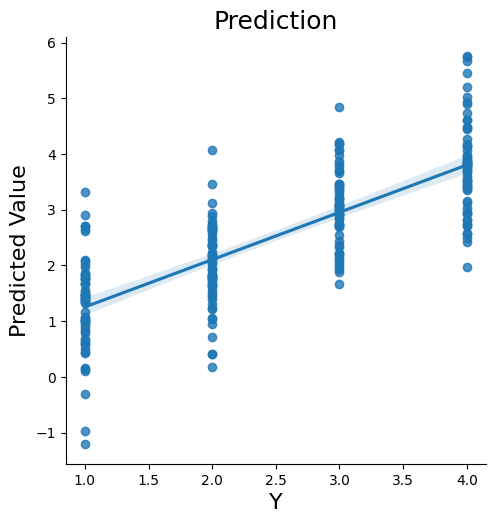

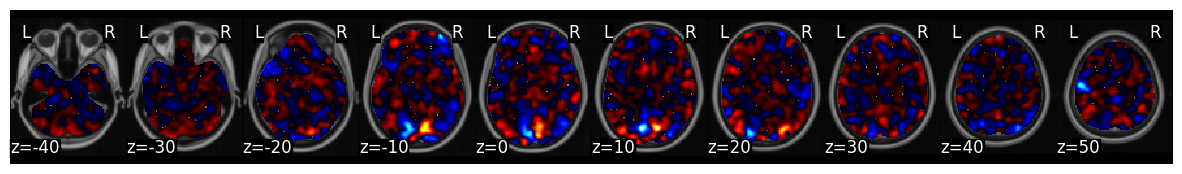

In [4]:
# Load brain data and remove subject mean
moral_data = Brain_Data(betas).standardize(axis=1)

# Load beta files into Brain_Data object
moral_data.X['subject'] = sub_info['subject']
moral_data.Y = sub_info['ratings']
subject_id = moral_data.X['subject']

# Remove subject mean and run svr
wb_stats = moral_data.predict(algorithm='svr', 
                              cv_dict={'type': 'loso','subject_id': subject_id}, 
                                                  plot=True, **{'kernel':"linear"})

# Write out weight map
wb_stats['weight_map'].write('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights.nii.gz')

# Write out cross-validation info
wb_stats['weight_map_xval'].write('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights_xval.nii.gz')

# While we are at it, write out the whole thing with pickle
with open('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights.pkl', 'wb') as f:
    pickle.dump(wb_stats, f)

# Store cross validation information
xval = pd.DataFrame({'Subject':[x for x in range(0,len(sub_info['subject']))]})
for i in range(64):
    xval[f'Train_{i}'] = 0
    xval.loc[wb_stats['cv_idx'][i][0], f'Train_{i}'] = 1
xval['Subject'] = sub_info['subject'].astype(str).apply(lambda x: 'sub-' + '{:02d}'.format(int(x)))
xval.to_csv('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_xval_split.csv', index=False)

In [5]:
wb_stats = pickle.load(open('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights.pkl', 'rb'))

## Average Overall Metrics

In [6]:
all_r, all_p = stats.pearsonr(sub_info['ratings'] , wb_stats['yfit_xval'])

all_rmse = root_mean_squared_error(sub_info['ratings'] , wb_stats['yfit_xval'])

print(f'Average overall (between- and within-subjects) correlation: r = {round(all_r, 2)}', all_p)
print(f'Average overall (between- and within-subjects) RMSE:  {round(all_rmse, 2)}')

Average overall (between- and within-subjects) correlation: r = 0.78 1.7956723236854011e-53
Average overall (between- and within-subjects) RMSE:  0.78


## Average Within-Subject Metrics

In [7]:
per_subject_ratings = [x.values for x in np.array_split(sub_info['ratings'] , len(sub_info.subject.unique()))]
per_subject_predictions = [x for x in np.array_split(wb_stats['yfit_xval'], len(sub_info.subject.unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    within_rmse.append(root_mean_squared_error(true, pred))

print(f'Average within-subject correlation: r = {round(np.mean(within_r), 2)} ± {round(scipy.stats.sem(within_r), 2)} (standard error (SE))')
print(f'Average RMSE: {round(np.mean(within_rmse), 2)} ± {round(scipy.stats.sem(within_rmse), 2)} (standard error (SE))')

Average within-subject correlation: r = 0.94 ± 0.02 (standard error (SE))
Average RMSE: 0.68 ± 0.05 (standard error (SE))


/home/fhopp/.conda/envs/mjs/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [8]:
mjs_r, mjs_p = stats.pearsonr(sub_info['ratings'] , wb_stats['yfit_xval'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(sub_info['ratings'], wb_stats['yfit_xval'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.78 1.7956723236854011e-53
MJS 95% CI: [0.736, 0.818]




In [9]:
mjs_r_within, mjs_r_within_se =  within_person_correlation(sub_info['ratings'], wb_stats['yfit_xval'], sub_info.subject)

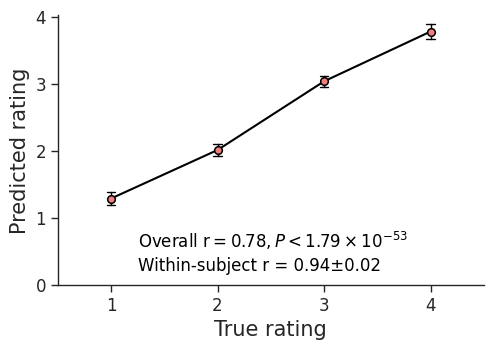

In [10]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], wb_stats['yfit_xval']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(all_r, 2), str(all_p)[0:4], str(all_p)[-2:]), 
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {mjs_r_within}±{mjs_r_within_se}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study1.png', dpi=300, bbox_inches='tight')
plt.show()

## Forced-Choice Tests

In [11]:
df_disc = sub_info.copy()
df_disc['MJS'] = wb_stats['yfit_xval']

In [12]:
cominations = [(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]
for c in cominations:
    fc_data = df_disc[df_disc['ratings'].isin(c)]
    fc_data = fc_data.groupby(['subject','ratings'])[['MJS']].mean().reset_index()
    fc_data = fc_data.dropna()
    fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==c[1] else False)
    fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
    fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

    roc = Roc(input_values=np.array(fc_data["MJS"].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.calculate()
    acc = roc.accuracy
    p_value = roc.accuracy_p.pvalue
    mantissa, exponent = f"{p_value:.2e}".split("e")
    exponent = exponent.lstrip("+-").replace("0", "⁰").replace("1", "¹").replace("2", "²").replace("3", "³").replace("4", "⁴").replace("5", "⁵").replace("6", "⁶").replace("7", "⁷").replace("8", "⁸").replace("9", "⁹")
    formatted_p = f"{mantissa} × 10⁻{exponent}"

    print(f'Accuracy for {c[0]} vs {c[1]}: {acc:.2f}, p-value: P < {formatted_p}')

Accuracy for 1 vs 2: 0.91, p-value: P < 9.03 × 10⁻¹²
Accuracy for 2 vs 3: 1.00, p-value: P < 1.08 × 10⁻¹⁹
Accuracy for 3 vs 4: 0.97, p-value: P < 2.26 × 10⁻¹⁶


Accuracy for 1 vs 3: 0.98, p-value: P < 7.05 × 10⁻¹⁸
Accuracy for 2 vs 4: 0.98, p-value: P < 7.05 × 10⁻¹⁸
Accuracy for 1 vs 4: 0.98, p-value: P < 7.05 × 10⁻¹⁸


***

# Validation Cohort

From the notes, sub-07 was moving a lot during the vignette task and did not pay attention during run-3, so will be discarded. 

In [13]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_2/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x and 'sub-07' not in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 30 unique subjects
assert len(sub_info.subject.unique()) == 30

In [14]:
# Load betas and subtract subject means
valid_data = Brain_Data(betas).standardize(axis=1)
valid_data.X['subject'] = sub_info['subject']
valid_data.Y = sub_info['ratings']
subject_id = valid_data.X['subject']

In [15]:
df_valid = pd.DataFrame()
df_valid['subject'] = sub_info['subject']
df_valid['ratings'] = sub_info['ratings']
df_valid['MJS'] = valid_data.similarity(wb_stats['weight_map'], method='dot_product') + wb_stats['intercept']

In [16]:
# pandas show all rows
pd.set_option('display.max_rows', None)

In [17]:
all_r, all_p = stats.pearsonr(df_valid['ratings'] , df_valid['MJS'])
all_rmse = root_mean_squared_error(df_valid['ratings'] , df_valid['MJS'])

print(f'Average overall (between- and within-subjects) correlation: r = {round(all_r, 2)}')
print(f'Average overall (between- and within-subjects) RMSE:  {round(all_rmse, 2)}')

per_subject_ratings = [x.values for x in np.array_split(df_valid['ratings'] , len(df_valid.subject.unique()))]
per_subject_predictions = [x for x in np.array_split(df_valid['MJS'], len(df_valid.subject.unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    within_rmse.append(root_mean_squared_error(true, pred))

print(f'Average within-subject correlation: r = {round(np.mean(within_r), 2)} ± {round(scipy.stats.sem(within_r), 2)} (standard error (SE))')
print(f'Average RMSE: {round(np.mean(within_rmse), 2)} ± {round(scipy.stats.sem(within_rmse), 2)} (standard error (SE))')

Average overall (between- and within-subjects) correlation: r = 0.6
Average overall (between- and within-subjects) RMSE:  1.09
Average within-subject correlation: r = 0.8 ± 0.05 (standard error (SE))
Average RMSE: 0.98 ± 0.09 (standard error (SE))


/home/fhopp/.conda/envs/mjs/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [18]:
mjs_r, mjs_p = stats.pearsonr(df_valid['ratings'] , df_valid['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_valid['ratings'], df_valid['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.6 5.796042099468889e-13
MJS 95% CI: [0.487, 0.701]




In [19]:
mjs_r_within, mjs_r_within_se =  within_person_correlation(df_valid['ratings'], df_valid['MJS'], df_valid.subject)

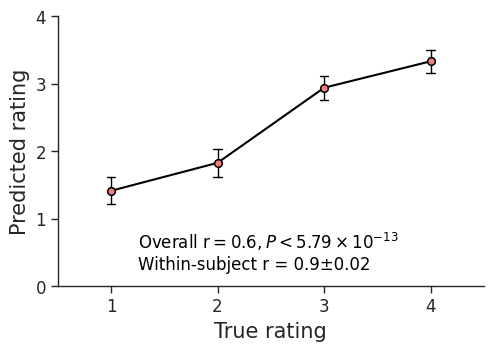

In [20]:
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='ratings', y='MJS', data=df_valid, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(all_r, 2), str(all_p)[0:4], str(all_p)[-2:]),
        color='black', fontsize=12)
ax.text(0.25, 0.25, f'Within-subject r = {mjs_r_within}±{mjs_r_within_se}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study2.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
## Forced-Choice
cominations = [(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]
for c in cominations:
    fc_data = df_valid[df_valid['ratings'].isin(c)]
    fc_data = fc_data.groupby(['subject','ratings'])[['MJS']].mean().reset_index()
    fc_data = fc_data.dropna()
    fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==c[1] else False)
    fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
    fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

    roc = Roc(input_values=np.array(fc_data["MJS"].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.calculate()
    acc = roc.accuracy
    p_value = roc.accuracy_p.pvalue
    mantissa, exponent = f"{p_value:.2e}".split("e")
    exponent = exponent.lstrip("+-").replace("0", "⁰").replace("1", "¹").replace("2", "²").replace("3", "³").replace("4", "⁴").replace("5", "⁵").replace("6", "⁶").replace("7", "⁷").replace("8", "⁸").replace("9", "⁹")
    formatted_p = f"{mantissa} × 10⁻{exponent}"

    print(f'Accuracy for {c[0]} vs {c[1]}: {acc:.2f}, p-value: P < {formatted_p}')

Accuracy for 1 vs 2: 0.76, p-value: P < 8.13 × 10⁻⁰³
Accuracy for 2 vs 3: 0.97, p-value: P < 5.77 × 10⁻⁰⁸
Accuracy for 3 vs 4: 0.83, p-value: P < 3.25 × 10⁻⁰⁴
Accuracy for 1 vs 3: 1.00, p-value: P < 3.73 × 10⁻⁰⁹
Accuracy for 2 vs 4: 1.00, p-value: P < 1.86 × 10⁻⁰⁹
Accuracy for 1 vs 4: 1.00, p-value: P < 3.73 × 10⁻⁰⁹


***
# Replication Cohort

In [22]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/duke/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 27 unique subjects
assert len(sub_info.subject.unique()) == 27

# We should have 108 beta maps
assert len(sub_info) == 27 * 4

In [23]:
# Load betas and take out subject means
repl_data = Brain_Data(betas).standardize(axis=1)
repl_data.X['subject'] = sub_info['subject']
repl_data.Y = sub_info['ratings']
subject_id = repl_data.X['subject']

In [24]:
df_repl = pd.DataFrame()
df_repl['subject'] = sub_info['subject']
df_repl['ratings'] = sub_info['ratings']
df_repl['MJS'] = repl_data.similarity(wb_stats['weight_map'], method='dot_product') + wb_stats['intercept']

In [25]:
all_r, all_p = stats.pearsonr(df_repl['ratings'] , df_repl['MJS'])
all_rmse = root_mean_squared_error(df_repl['ratings'] , df_repl['MJS'])

print(f'Average overall (between- and within-subjects) correlation: r = {round(all_r, 2)}')
print(f'Average overall (between- and within-subjects) RMSE:  {round(all_rmse, 2)}')

Average overall (between- and within-subjects) correlation: r = 0.49
Average overall (between- and within-subjects) RMSE:  1.16


In [26]:
within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    within_rmse.append(root_mean_squared_error(true, pred))

print(f'Average within-subject correlation: r = {round(np.mean(within_r), 2)} ± {round(scipy.stats.sem(within_r), 2)} (standard error (SE))')
print(f'Average RMSE: {round(np.mean(within_rmse), 2)} ± {round(scipy.stats.sem(within_rmse), 2)} (standard error (SE))')

Average within-subject correlation: r = 0.8 ± 0.05 (standard error (SE))
Average RMSE: 0.98 ± 0.09 (standard error (SE))


In [27]:
mjs_r, mjs_p = stats.pearsonr(df_repl['ratings'] , df_repl['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_repl['ratings'], df_repl['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.49 7.355123318790087e-08
MJS 95% CI: [0.344, 0.625]




In [28]:
mjs_r_within, mjs_r_within_se =  within_person_correlation(df_repl['ratings'], df_repl['MJS'], df_repl.subject)

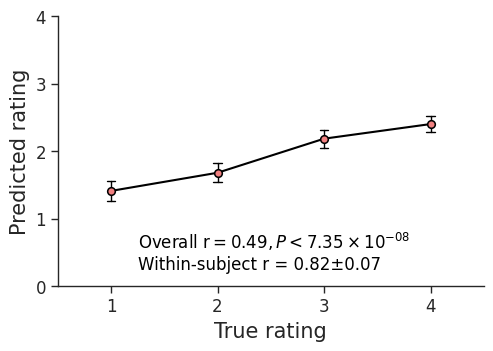

In [29]:
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='ratings', y='MJS', data=df_repl, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(all_r, 2), str(all_p)[0:4], str(all_p)[-2:]),
        color='black', fontsize=12)
ax.text(0.25, 0.25, f'Within-subject r = {mjs_r_within}±{mjs_r_within_se}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study3.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
## Forced-Choice
cominations = [(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]
for c in cominations:
    fc_data = df_repl[df_repl['ratings'].isin(c)]
    fc_data = fc_data.groupby(['subject','ratings'])[['MJS']].mean().reset_index()
    fc_data = fc_data.dropna()
    fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==c[1] else False)
    fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
    fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

    roc = Roc(input_values=np.array(fc_data["MJS"].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.calculate()
    acc = roc.accuracy
    p_value = roc.accuracy_p.pvalue
    mantissa, exponent = f"{p_value:.2e}".split("e")
    exponent = exponent.lstrip("+-").replace("0", "⁰").replace("1", "¹").replace("2", "²").replace("3", "³").replace("4", "⁴").replace("5", "⁵").replace("6", "⁶").replace("7", "⁷").replace("8", "⁸").replace("9", "⁹")
    formatted_p = f"{mantissa} × 10⁻{exponent}"

    print(f'Accuracy for {c[0]} vs {c[1]}: {acc:.2f}, p-value: P < {formatted_p}')

Accuracy for 1 vs 2: 0.74, p-value: P < 1.92 × 10⁻⁰²
Accuracy for 2 vs 3: 0.96, p-value: P < 4.17 × 10⁻⁰⁷
Accuracy for 3 vs 4: 0.81, p-value: P < 1.51 × 10⁻⁰³
Accuracy for 1 vs 3: 0.96, p-value: P < 4.17 × 10⁻⁰⁷
Accuracy for 2 vs 4: 0.96, p-value: P < 4.17 × 10⁻⁰⁷
Accuracy for 1 vs 4: 0.93, p-value: P < 5.65 × 10⁻⁰⁶


***
# Generalization

In [31]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/uva/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 30 unique subjects
assert len(sub_info.subject.unique()) == 30

# We should have 120 beta maps
assert len(sub_info) == 30 * 4

In [32]:
# Load betas and take out subject means
gen_data = Brain_Data(betas).standardize(axis=1)
gen_data.X['subject'] = sub_info['subject']
gen_data.Y = sub_info['ratings']
subject_id = gen_data.X['subject']

In [33]:
df_gen = pd.DataFrame()
df_gen['subject'] = sub_info['subject']
df_gen['ratings'] = sub_info['ratings']
df_gen['MJS'] = gen_data.similarity(wb_stats['weight_map'], method='dot_product') + wb_stats['intercept']

In [34]:
all_r, all_p = stats.pearsonr(df_gen['ratings'] , df_gen['MJS'])
all_rmse = root_mean_squared_error(df_gen['ratings'] , df_gen['MJS'])

print(f'Average overall (between- and within-subjects) correlation: r = {round(all_r, 2)}')
print(f'Average overall (between- and within-subjects) RMSE:  {round(all_rmse, 2)}')

per_subject_ratings = [x.values for x in np.array_split(df_gen['ratings'] , len(df_gen.subject.unique()))]
per_subject_predictions = [x for x in np.array_split(df_gen['MJS'], len(sub_info.subject.unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    within_rmse.append(root_mean_squared_error(true, pred))

print(f'Average within-subject correlation: r = {round(np.mean(within_r), 2)} ± {round(scipy.stats.sem(within_r), 2)} (standard error (SE))')
print(f'Average RMSE: {round(np.mean(within_rmse), 2)} ± {round(scipy.stats.sem(within_rmse), 2)} (standard error (SE))')

Average overall (between- and within-subjects) correlation: r = 0.42
Average overall (between- and within-subjects) RMSE:  1.09
Average within-subject correlation: r = 0.91 ± 0.02 (standard error (SE))
Average RMSE: 1.03 ± 0.07 (standard error (SE))


/home/fhopp/.conda/envs/mjs/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [35]:
mjs_r, mjs_p = stats.pearsonr(df_gen['ratings'] , df_gen['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_gen['ratings'], df_gen['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.42 1.8520614146948228e-06
MJS 95% CI: [0.274, 0.547]




In [36]:
mjs_r_within, mjs_r_within_se =  within_person_correlation(df_gen['ratings'], df_gen['MJS'], df_gen.subject)

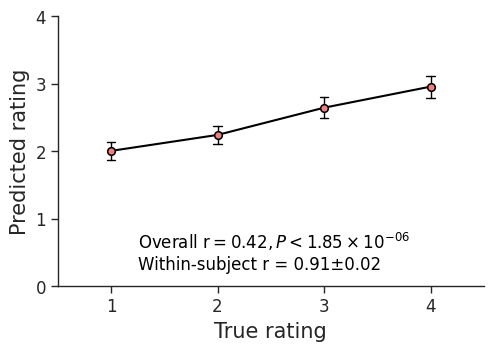

In [37]:
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='ratings', y='MJS', data=df_gen, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(all_r, 2), str(all_p)[0:4], str(all_p)[-2:]),
        color='black', fontsize=12)
ax.text(0.25, 0.25, f'Within-subject r = {mjs_r_within}±{mjs_r_within_se}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
# change size of ytick label to 12
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study4.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
## Forced-Choice
cominations = [(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]
for c in cominations:
    fc_data = df_gen[df_gen['ratings'].isin(c)]
    fc_data = fc_data.groupby(['subject','ratings'])[['MJS']].mean().reset_index()
    fc_data = fc_data.dropna()
    fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==c[1] else False)
    fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
    fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

    roc = Roc(input_values=np.array(fc_data["MJS"].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.calculate()
    acc = roc.accuracy
    p_value = roc.accuracy_p.pvalue
    mantissa, exponent = f"{p_value:.2e}".split("e")
    exponent = exponent.lstrip("+-").replace("0", "⁰").replace("1", "¹").replace("2", "²").replace("3", "³").replace("4", "⁴").replace("5", "⁵").replace("6", "⁶").replace("7", "⁷").replace("8", "⁸").replace("9", "⁹")
    formatted_p = f"{mantissa} × 10⁻{exponent}"

    print(f'Accuracy for {c[0]} vs {c[1]}: {acc:.2f}, p-value: P < {formatted_p}')

Accuracy for 1 vs 2: 0.80, p-value: P < 1.43 × 10⁻⁰³
Accuracy for 2 vs 3: 0.97, p-value: P < 5.77 × 10⁻⁰⁸
Accuracy for 3 vs 4: 0.77, p-value: P < 5.22 × 10⁻⁰³
Accuracy for 1 vs 3: 0.97, p-value: P < 5.77 × 10⁻⁰⁸
Accuracy for 2 vs 4: 0.97, p-value: P < 5.77 × 10⁻⁰⁸
Accuracy for 1 vs 4: 1.00, p-value: P < 1.86 × 10⁻⁰⁹


***